In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy

## Load data to fit "ground truth" curves

In [3]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [4]:
def func(x, a, b, c):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*x**b + c

In [5]:
params = []
cycle_lives = []
#pred_cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])

    cycle_lives.append(bat["cycle_life"][0])
    #pred_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-gamma),1/beta)])
params = np.array(params)
cycle_lives = np.array(cycle_lives)
#pred_cycle_lives = np.array(pred_cycle_lives)

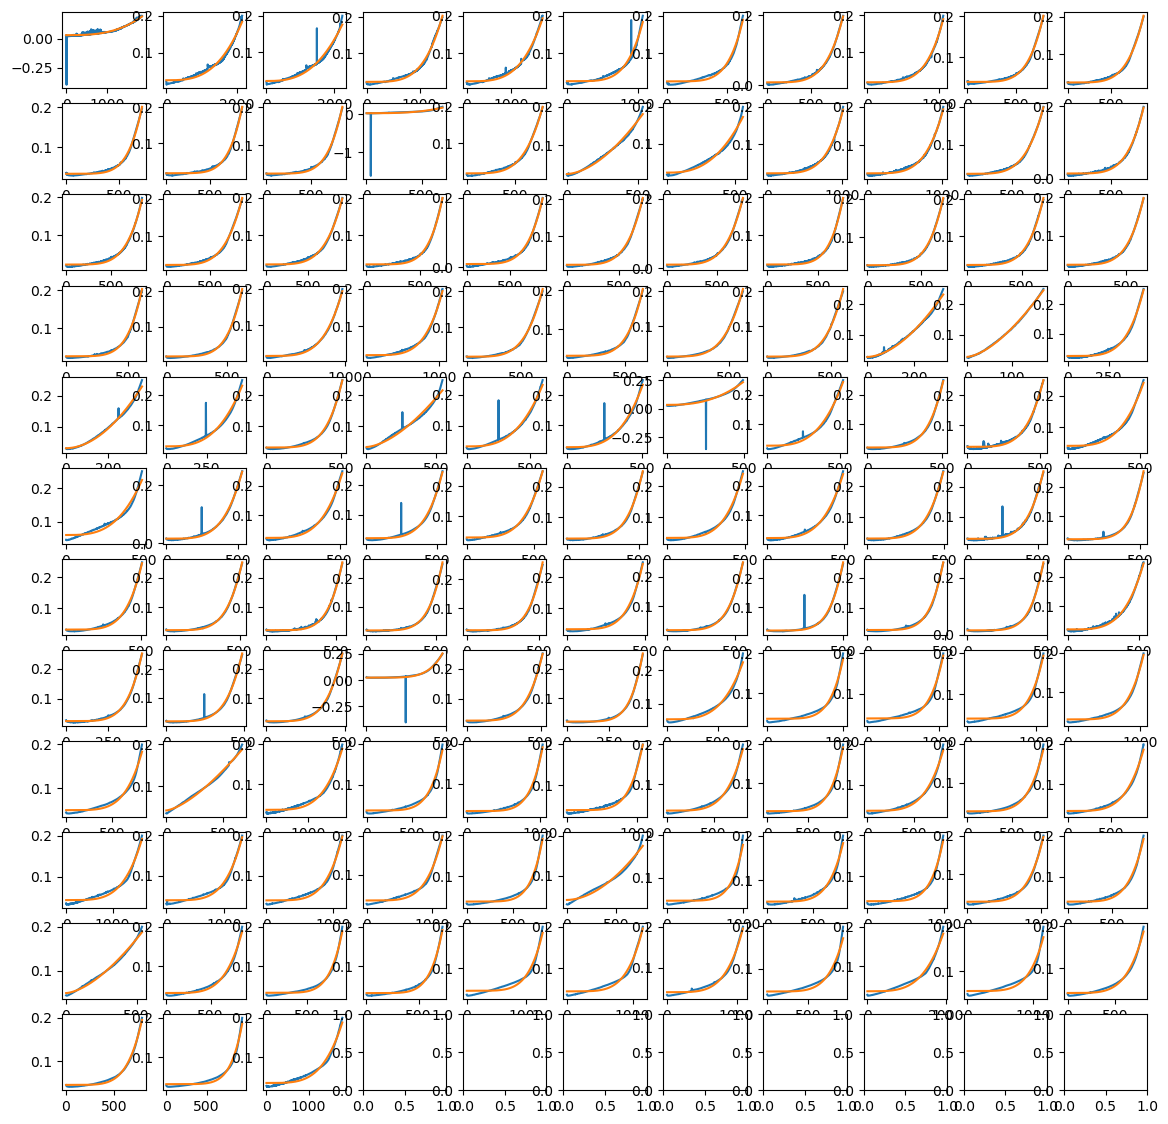

In [6]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

In [11]:
def analytic_cycle_life(params):
    a, b, c = params
    return np.power(np.exp(-a)*(0.2-c),1/b)

def counting_cycle_life(params):
    a, b, c = params
    x = np.arange(1, 2500)
    curve = np.exp(a)*np.power(x, b) + c
    return np.sum(curve < 0.2)

b1c0	1881.849495319819	1881	1852.0
b1c1	2227.1131296949934	2227	2160.0
b1c2	2359.0790746947077	2359	2237.0
b1c3	1423.764483239223	1423	1434.0
b1c4	1726.2779351476681	1726	1709.0
b1c5	1095.0274662804798	1095	1074.0
b1c6	641.8515475379809	641	636.0
b1c7	870.8920783237658	870	870.0
b1c9	1065.3988290426844	1065	1054.0
b1c11	785.4051850426993	785	788.0
b1c14	875.829399470262	875	880.0
b1c15	715.8368467268837	715	719.0
b1c16	859.3116846337962	859	862.0
b1c17	854.6597514505742	854	857.0
b1c18	721.0869460051578	721	691.0
b1c19	785.9548626266271	785	788.0
b1c20	569.6254839598124	569	534.0
b1c21	593.4123956300733	593	559.0
b1c23	1022.1208446638102	1022	1014.0
b1c24	1024.5599087307526	1024	1017.0
b1c25	853.7903700521201	853	854.0
b1c26	871.2480702654286	871	870.0
b1c27	846.0462330951319	846	842.0
b1c28	855.3635082723855	855	860.0
b1c29	917.03126082305	917	917.0
b1c30	706.8279545337306	706	709.0
b1c31	876.0182695706841	876	876.0
b1c32	726.6222358915769	726	731.0
b1c33	752.7748749347145	752	757.0
b

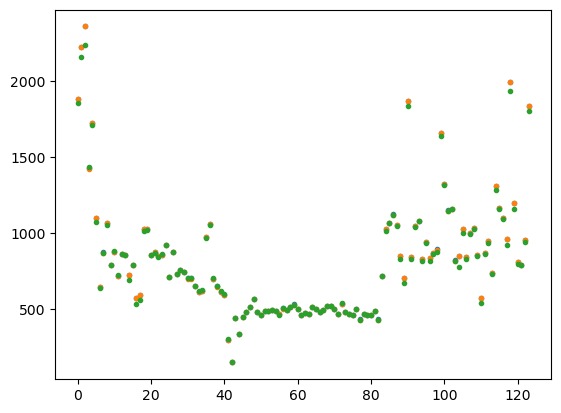

In [30]:
cls1 = []
cls2 = []
cls_true = []
for ix,id in enumerate(bat_dict.keys()):
    cl1 = analytic_cycle_life(params[ix])
    cl2 = counting_cycle_life(params[ix])
    cl_true = bat_dict[id]["cycle_life"].item()
    print(id, cl1, cl2, cl_true, sep = "\t")
    for cl, list in zip([cl1, cl2, cl_true], [cls1, cls2, cls_true]):
        list.append(cl)
plt.plot(cls1, ".")
plt.plot(cls2, ".")
plt.plot(cls_true, ".")
print(np.mean(np.array(cls1) - np.array(cls2)))
print(np.mean(np.array(cls1) - np.array(cls_true)))

## Load data for predictive model

In [31]:
# features4 uses Severson interpolated data AND takes the log of all statistical features
# can try features3, which still uses Severson data but without the log of min, mean, skew kurtosis
data = np.loadtxt('./../Data/features4.csv',delimiter=',',skiprows=1) # skip row for column names

In [32]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [33]:
# logVar, logMean, logMin, logSkew, logKurtosis
x_train = data[:,1:6][train_ind]
y_train = params[train_ind]
life_train = cycle_lives[train_ind]

x_test = data[:,1:6][test_ind]
y_test = params[test_ind]
life_test = cycle_lives[test_ind]

x_stest = data[:,1:6][secondary_ind]
y_stest = params[secondary_ind]
life_stest = cycle_lives[secondary_ind]

In [34]:
train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(life_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(life_test))
stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(life_stest))

In [35]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        #self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## First round of training (calc loss w/ model parameters)

In [63]:
d_model = 2
feat_dim = 1
n_cycle = np.shape(x_train)[1]
attn_model = "softmax"
skip_connect = 0
nepoch = 1000
lr = 1e-3
batch_size = 1

In [64]:
model = AttentionModel(d_model=d_model,feat_dim=feat_dim,n_cycle=n_cycle,vdim=3,attn_model=attn_model,skip_connect=skip_connect)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label, _ = batch
        output = model(train_input.to(device))
        
        loss = criterion(output, train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label, _ = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(test_output, test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, _ = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(stest_output, stest_label)
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 50 | rmse:  12.499 | rmse_test:  12.233 | rmse_stest:  15.132
Epochs: 100 | rmse:  8.360 | rmse_test:  8.169 | rmse_stest:  10.597
Epochs: 150 | rmse:  5.260 | rmse_test:  5.287 | rmse_stest:  7.139
Epochs: 200 | rmse:  3.762 | rmse_test:  4.136 | rmse_stest:  5.250
Epochs: 250 | rmse:  3.488 | rmse_test:  4.043 | rmse_stest:  4.701
Epochs: 300 | rmse:  3.471 | rmse_test:  4.067 | rmse_stest:  4.598
Epochs: 350 | rmse:  3.469 | rmse_test:  4.076 | rmse_stest:  4.575
Epochs: 400 | rmse:  3.469 | rmse_test:  4.077 | rmse_stest:  4.573
Epochs: 450 | rmse:  3.468 | rmse_test:  4.078 | rmse_stest:  4.568
Epochs: 500 | rmse:  3.466 | rmse_test:  4.074 | rmse_stest:  4.568
Epochs: 550 | rmse:  3.462 | rmse_test:  4.074 | rmse_stest:  4.558
Epochs: 600 | rmse:  3.455 | rmse_test:  4.077 | rmse_stest:  4.545
Epochs: 650 | rmse:  3.452 | rmse_test:  4.080 | rmse_stest:  4.531
Epochs: 700 | rmse:  3.451 | rmse_test:  4.082 | rmse_stest:  4.520
Epochs: 750 | rmse:  3.447 | rmse_test:  4.08

212.99366921515872
267.00473449650804
309.2094431236383


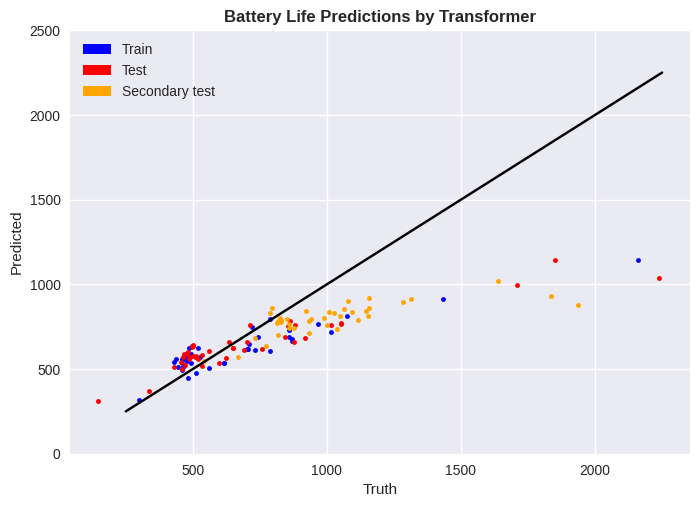

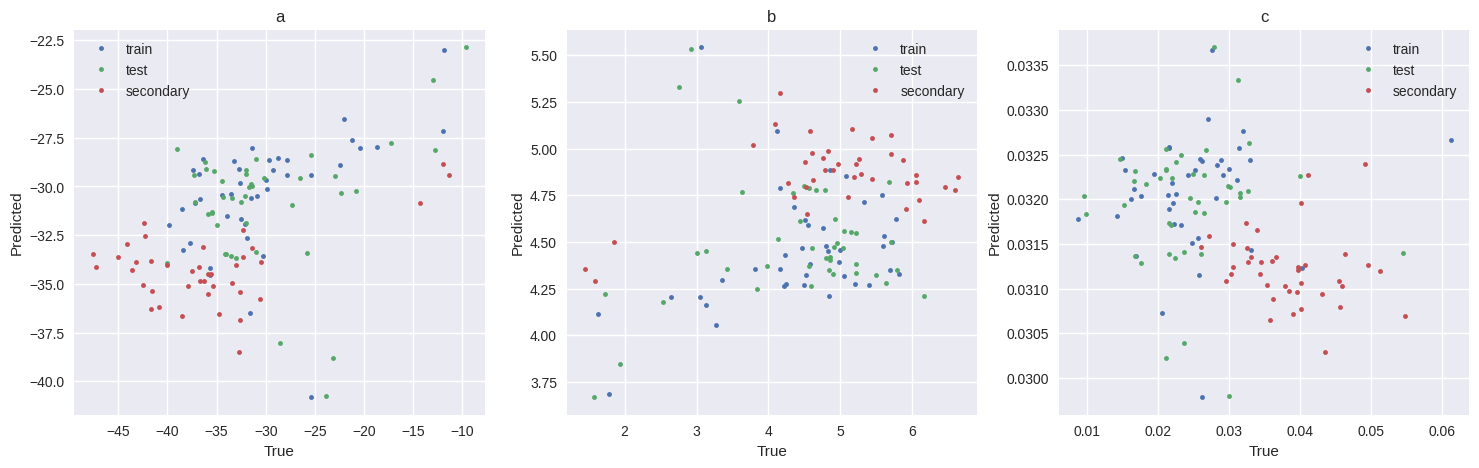

In [65]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 3)
for i, title in zip(range(3), ["a", "b", "c"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()

## Second round of training (calc loss w/ cycle lifetime)

In [108]:
# create a deep copy of model to fine tune
#model2 = copy.deepcopy(model)

In [98]:
# low learning rate and many epochs for fine-tuning
lr_fine = 1e-5
optimizer_fine = torch.optim.Adam(model.parameters(), lr=lr_fine)
nepoch = 3000

In [118]:
# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life = batch
        output = model(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-output[:,2]),1/output[:,1])
        #true_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        if torch.isnan(pred_life): 
            print(output)
            break

        #loss = criterion(output, train_label)
        loss = criterion(pred_life,true_life)
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-test_output[:,2]),1/test_output[:,1])
        #true_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        test_loss = criterion(pred_life,true_life)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-stest_output[:,2]),1/stest_output[:,1])
        #true_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        stest_loss = criterion(pred_life,true_life)
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

c:\Users\kyan3\miniconda3\envs\toyota\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 100 | rmse:  115.511 | rmse_test:  141.208 | rmse_stest:  197.391
Epochs: 200 | rmse:  114.174 | rmse_test:  138.945 | rmse_stest:  197.436
Epochs: 300 | rmse:  113.260 | rmse_test:  136.962 | rmse_stest:  197.590
Epochs: 400 | rmse:  112.403 | rmse_test:  135.281 | rmse_stest:  197.771
Epochs: 500 | rmse:  111.768 | rmse_test:  133.863 | rmse_stest:  198.278
Epochs: 600 | rmse:  111.349 | rmse_test:  132.731 | rmse_stest:  198.511
Epochs: 700 | rmse:  111.261 | rmse_test:  131.838 | rmse_stest:  198.839
Epochs: 800 | rmse:  110.931 | rmse_test:  131.136 | rmse_stest:  198.992
Epochs: 900 | rmse:  110.723 | rmse_test:  130.612 | rmse_stest:  199.327
Epochs: 1000 | rmse:  110.629 | rmse_test:  130.201 | rmse_stest:  199.589
Epochs: 1100 | rmse:  110.519 | rmse_test:  129.886 | rmse_stest:  199.697
Epochs: 1200 | rmse:  110.496 | rmse_test:  129.656 | rmse_stest:  199.935
Epochs: 1300 | rmse:  110.446 | rmse_test:  129.438 | rmse_stest:  199.925
Epochs: 1400 | rmse:  110.240 | rm

109.34979004471083
128.2753064947772
200.08470336237153


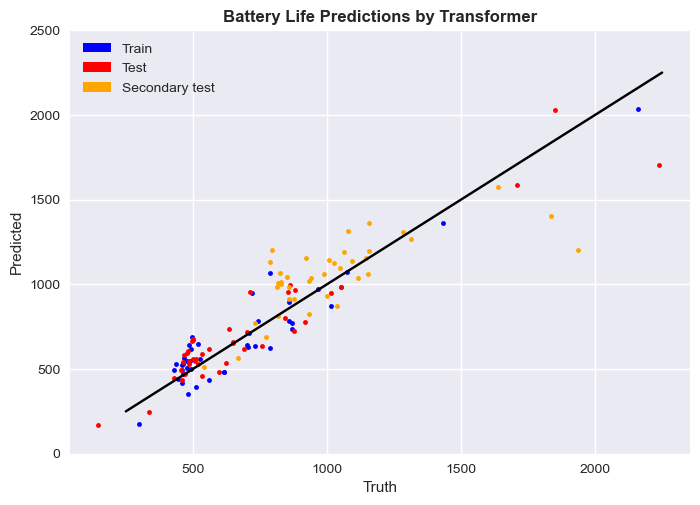

In [120]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])

        predicted.append(pred_life)
        labels.append(true_life[0])
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.savefig('greaterror.png')